In [4]:
from pathlib import Path
from scipy.stats import pearsonr
import numpy as np

import torch.nn as nn
import matplotlib.pyplot as plt

import uncertainties as unc
import dataloaders as dl
import models as m

import inspect
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

num=2000
batch_size = 200
test_num=2000
def entropy(x):
    return -x*np.log2(x) - (1-x)*np.log2(1-x)

In [5]:
def generate_mlp(input_size: int, cfg= None, initial_dropout=0.5, output_layer="softmax"):
    if cfg is None:
        cfg = [256, 512, 256, 2]
    layers = [
        nn.Flatten(),
        nn.Linear(input_size, cfg[0]),
        nn.ReLU(),
        nn.Dropout(initial_dropout)
    ]
    if len(cfg) > 1:
        for w1, w2 in zip(cfg[:-2], cfg[1:-1]):
            layers += [nn.Linear(w1, w2), nn.ReLU(),nn.Dropout(initial_dropout)]
    layers += [nn.Linear(cfg[-2], cfg[-1])]
    return nn.Sequential(*layers)


In [6]:
import torch

class Conv1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 50, 4),
            nn.Conv1d(50, 100, 4),
            nn.MaxPool1d(4), #output size = 300
            nn.Flatten(),
            nn.Linear(300, 64),
            nn.LeakyReLU(),
            nn.Dropout(.5),
            nn.Linear(64, 64),
            nn.LeakyReLU(),
            nn.Dropout(.5),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(.5),
            nn.Linear(32, 2),
            )
    def forward(self, x):
        return self.model(x.view(x.size(0),1,-1))

In [7]:
conv1d_model = Conv1d()

# Definicja niepewności

In [5]:
num=2000
batch_size = 200
test_num=2000
def calculate(num, cfg):
    model = cfg if not isinstance(cfg, list) else generate_mlp(20, cfg)
    device='cuda:0'
    data_loader_train, data_loader_test, data_loader_train_r, data_loader_test_r = dl.get_dataloaders(num, batch_size)
    contextual_data_loader = dl.get_dataloaders_c(test_num, batch_size)

    classifier = m.Classifier(data_loader_train, data_loader_test, model, device)
    accuracies = classifier.train_and_eval()
    preds = classifier.pred(contextual_data_loader)
    dropout_var, dropout_mean, dropout_raw_var = unc.get_preds_dropout(contextual_data_loader, classifier.model, device)
    laplace_var, laplace_mean = unc.get_preds_laplace(data_loader_train, contextual_data_loader, classifier.model, device)
    dists=[]
    for X, y in contextual_data_loader:
        dists.extend([dl.projection_distance(x.numpy()) for x in X])
    def entropy(x):
        return x*np.log2(x) + (1-x)*np.log2(1-x)
    values = [preds, entropy(preds), laplace_mean, entropy(laplace_mean), dropout_mean, entropy(dropout_mean), laplace_var, dropout_var, dropout_raw_var]
    return np.mean(dropout_var), np.mean(laplace_var), np.mean(dropout_raw_var), accuracies, values, dists

In [8]:
results = [] 
cfgs = [[32,32,16,16,2], [64,32,16,2], [128,64,16,2], [128,32,16,2], [64,16,2], [32,16,2]]
cfgs = [conv1d_model, [128,64,16,2], [64,32,16,2], [64,16,2]]
for n in cfgs:
    r = map(lambda x: calculate(x, n), range(500, 30000, 500))
    results.append(list(r))
    print(f"skończyłem {n}")

Classifier learn has finished with acc: 0.515
Test acc: 0.456
Classifier learn has finished with acc: 0.884
Test acc: 0.872
Classifier learn has finished with acc: 0.948
Test acc: 0.925
Classifier learn has finished with acc: 0.973
Test acc: 0.948
Classifier learn has finished with acc: 0.971
Test acc: 0.965
Classifier learn has finished with acc: 0.980
Test acc: 0.963
Classifier learn has finished with acc: 0.985
Test acc: 0.968
Classifier learn has finished with acc: 0.984
Test acc: 0.971
Classifier learn has finished with acc: 0.979
Test acc: 0.963
Classifier learn has finished with acc: 0.958
Test acc: 0.954
Classifier learn has finished with acc: 0.982
Test acc: 0.964
Classifier learn has finished with acc: 0.986
Test acc: 0.973
Classifier learn has finished with acc: 0.981
Test acc: 0.974
Classifier learn has finished with acc: 0.985
Test acc: 0.975
Classifier learn has finished with acc: 0.989
Test acc: 0.970
Classifier learn has finished with acc: 0.988
Test acc: 0.974
Classifi

Classifier learn has finished with acc: 0.515
Test acc: 0.456
Classifier learn has finished with acc: 0.511
Test acc: 0.468
Classifier learn has finished with acc: 0.637
Test acc: 0.574
Classifier learn has finished with acc: 0.500
Test acc: 0.501
Classifier learn has finished with acc: 0.504
Test acc: 0.488
Classifier learn has finished with acc: 0.756
Test acc: 0.750
Classifier learn has finished with acc: 0.929
Test acc: 0.916
Classifier learn has finished with acc: 0.939
Test acc: 0.939
Classifier learn has finished with acc: 0.915
Test acc: 0.911
Classifier learn has finished with acc: 0.938
Test acc: 0.933
Classifier learn has finished with acc: 0.953
Test acc: 0.951
Classifier learn has finished with acc: 0.922
Test acc: 0.910
Classifier learn has finished with acc: 0.932
Test acc: 0.914
Classifier learn has finished with acc: 0.946
Test acc: 0.938
Classifier learn has finished with acc: 0.947
Test acc: 0.944
Classifier learn has finished with acc: 0.941
Test acc: 0.945
Classifi

/tmp/ipykernel_21063/3447271285.py:21: RuntimeWarning: divide by zero encountered in log2
  return -x*np.log2(x) - (1-x)*np.log2(1-x)
/tmp/ipykernel_21063/3447271285.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return -x*np.log2(x) - (1-x)*np.log2(1-x)


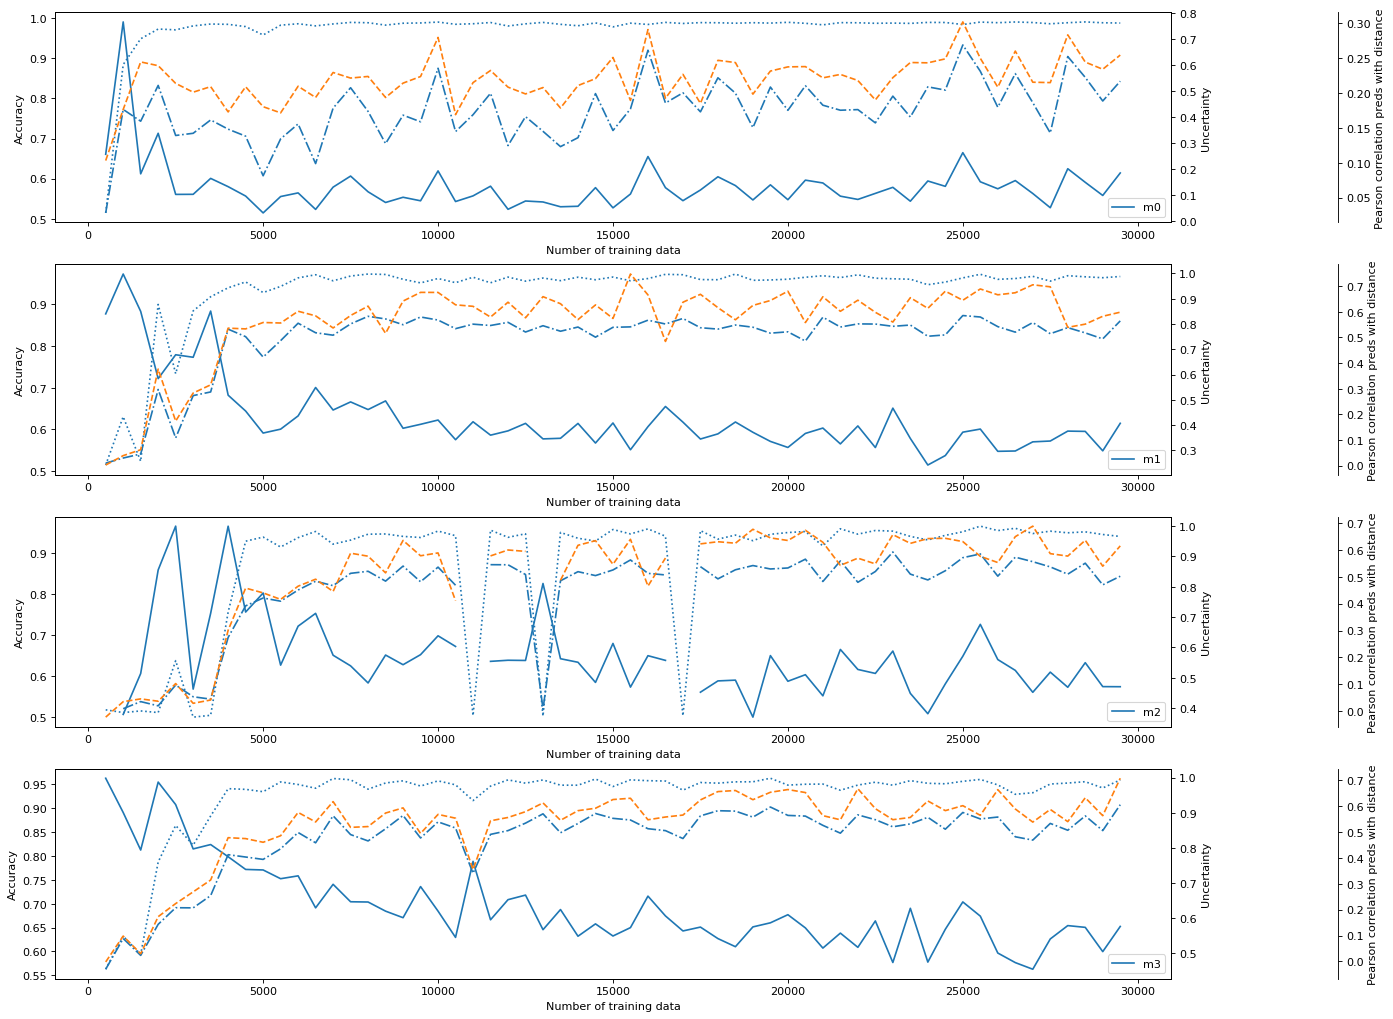

In [16]:
plt.figure(figsize=(18, 16), dpi=80)
num=len(results)
for i in range(num):        
    ax1 = plt.subplot(num,1,i+1)
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax1.set_xlabel('Number of training data')
    ax1.set_ylabel('Accuracy')
    ax2.set_ylabel('Uncertainty')
    ax3.set_ylabel('Pearson correlation preds with distance')
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    ax3.spines.right.set_position(("axes", 1.15))
    #ax4 = ax1.twinx()
    #ax4.set_ylabel('Pearson correlation DO with distance')
    #ax4.spines.right.set_position(("axes", 1.25))

    ax1.plot(range(500, 30000, 500), [elem[3][1] for elem in results[i]], label = 'm' + str(i), linestyle='dotted')
    ax2.plot(range(500, 30000, 500), list(map(entropy, np.array(results, dtype=object)[i][:, 0]/100)), label = 'm' + str(i))
    ax2.legend(loc=4)
    ax3.plot(range(500, 30000, 500), [-pearsonr(a,b)[0] for a,b in zip([k[5] for k in results[i]], [k[4][-2] for k in results[i]])], label = 'm' + str(i), linestyle='dashdot')
    ax3.plot(range(500, 30000, 500), [pearsonr(a,b)[0] for a,b in zip([k[5] for k in results[i]], [k[4][0] for k in results[i]])],label = 'm' + str(i), linestyle='dashed')
#plt.set_title("Accuracy and Uncertainty vs number of training data in Dropout MCMC")

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax2 = ax1.twinx()
ax1.set_xlabel('Number of training data')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Uncertainty')
for i in range(3):
    print(i)
    ax1.plot(range(2000, 20000, 500), [elem[3][0] for elem in results[i]], label = 'm' + str(i), linestyle='dotted')
    ax2.plot(range(2000, 20000, 500), np.array(results, dtype=object)[i][:, 1], label = 'm' + str(i))
ax2.legend(loc=4)
ax2.set_title("Accuracy and Uncertainty vs number of training data in Laplace")

In [ ]:
from scipy.stats import pearsonr
for i in range(5):
    print(pearsonr([elem[3][1] for elem in results[i]],
                   list(map(entropy, np.array(results, dtype=object)[i][:, 0]/100)))
         )

In [ ]:
plt.plot(list(map(entropy, np.array(results, dtype=object)[2][:, 0]/100)))

# Pojedyncza sieć - analiza

In [8]:
def plot_histograms(arr, idx, arr2=None):
    if arr2 is None:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), sharex=True)
        ax1.hist(arr[idx])
        ax2.hist(arr)
    else:
        fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2,2, figsize=(10,10), sharex="col")
        ax1.hist(arr[idx])
        ax2.hist(arr)
        ax3.hist(arr2[idx])
        ax4.hist(arr2)

In [10]:
num=10000
batch_size = 200
test_num=20000
model = generate_mlp(20, [64,32,2])
device='cuda:0'
data_loader_train, data_loader_test, data_loader_train_r, data_loader_test_r = dl.get_dataloaders(num, batch_size)
contextual_data_loader = dl.get_dataloaders_c(test_num, batch_size)

classifier = m.Classifier(data_loader_train, data_loader_test, model, device)
accuracies = classifier.train_and_eval()
preds = classifier.pred(contextual_data_loader)
dropout_var, dropout_mean, dropout_raw_var = unc.get_preds_dropout(contextual_data_loader, classifier.model, device)
laplace_var, laplace_mean = unc.get_preds_laplace(data_loader_train, contextual_data_loader, classifier.model, device)
dists=[]
for X, y in contextual_data_loader:
    dists.extend([dl.projection_distance(x.numpy()) for x in X])
def entropy(x):
    return x*np.log2(x) + (1-x)*np.log2(1-x)

values = [preds, entropy(preds), laplace_mean, entropy(laplace_mean), dropout_mean, entropy(dropout_mean), laplace_var, dropout_var, dropout_raw_var]

Classifier learn has finished with acc: 0.947
Test acc: 0.942


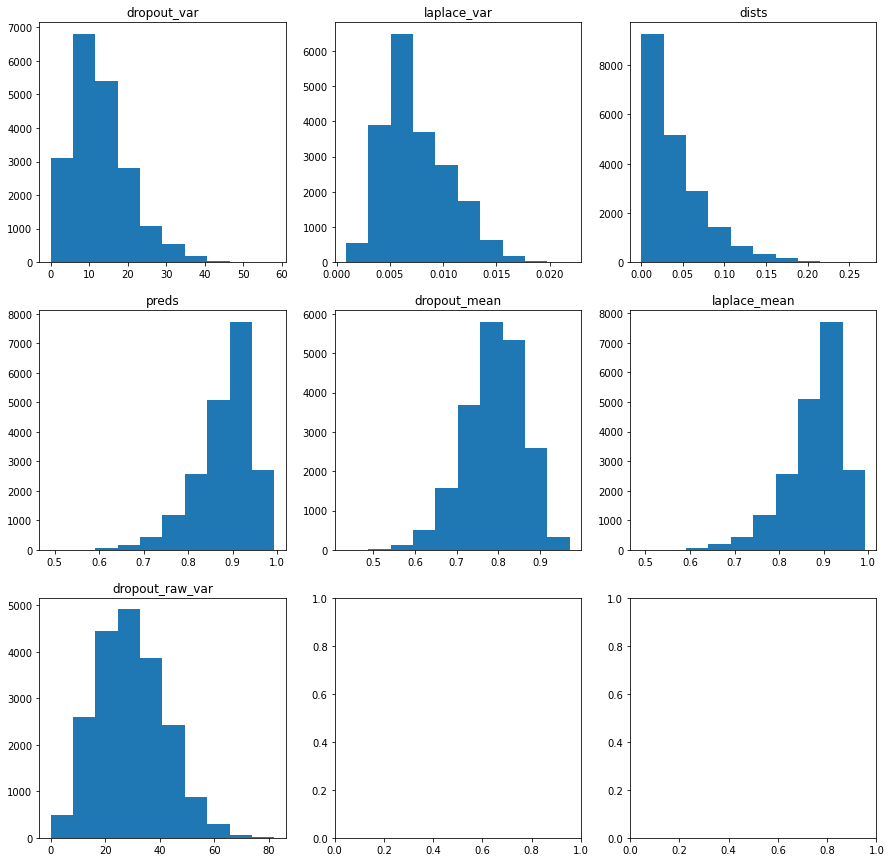

In [11]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
for i, x in enumerate([dropout_var, laplace_var, dists, preds, dropout_mean, laplace_mean, dropout_raw_var]):
    axs[i//3, i%3].hist(x)
    axs[i//3, i%3].set_title(retrieve_name(x)[0])
    

## Niepewność błędnie zaklasyfikowanych

In [12]:
c_num = 0
nc_num = 0
cont = 0
ncont = 0 
for x,y in data_loader_test:
    y_hat = (torch.min(classifier.model(x), dim=1).indices+1)%2
    print(y, y_hat)
    cont += np.where((y_hat == y[0]) & (y[0]==1))[0].shape[0]
    ncont += np.where((y_hat == y[0]) & (y[0]==0))[0].shape[0]
    c_num += np.where(y==1)[0].shape[0]
    nc_num += np.where(y==0)[0].shape[0]


tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       

In [69]:
def collate_fn(self, batch):
    batch = list(filter(lambda x: x != 1, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
from torch.utils.data import DataLoader
DataLoder(contextual_data_loader, collate_fn=)

In [17]:
classifier.pred(contextual_data_loader)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

(array([6.000e+00, 1.500e+01, 8.000e+01, 1.840e+02, 4.500e+02, 1.182e+03,
        2.565e+03, 5.070e+03, 7.733e+03, 2.715e+03]),
 array([0.49080047, 0.541064  , 0.59132755, 0.6415911 , 0.6918546 ,
        0.7421182 , 0.7923817 , 0.8426452 , 0.8929088 , 0.94317234,
        0.99343586], dtype=float32),
 <BarContainer object of 10 artists>)

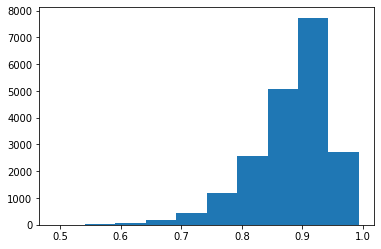

In [28]:
plt.hist(classifier.pred(contextual_data_loader))

In [ ]:
classifier.pred(contextual_data_loader)

In [ ]:
classifier.model(x)

In [95]:
cont/c_num

0.5468998410174881

In [96]:
ncont/nc_num

0.4468599033816425

In [97]:
cont+ncont

1243

In [79]:
c_num + nc_num

2500

In [14]:
idx

array([9266])

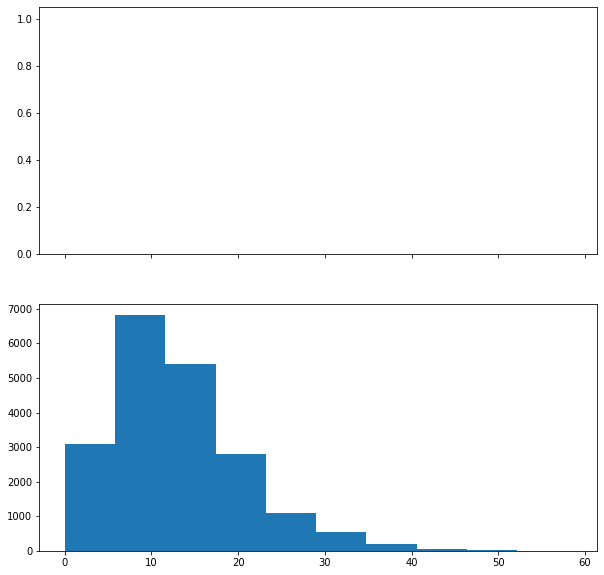

In [13]:
idx = np.where(preds<0.5)[0]
plot_histograms(dropout_var, idx)

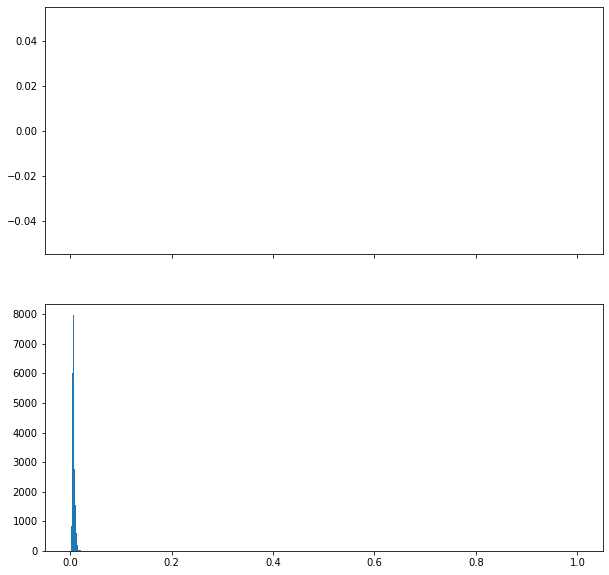

In [35]:
plot_histograms(laplace_var, idx)

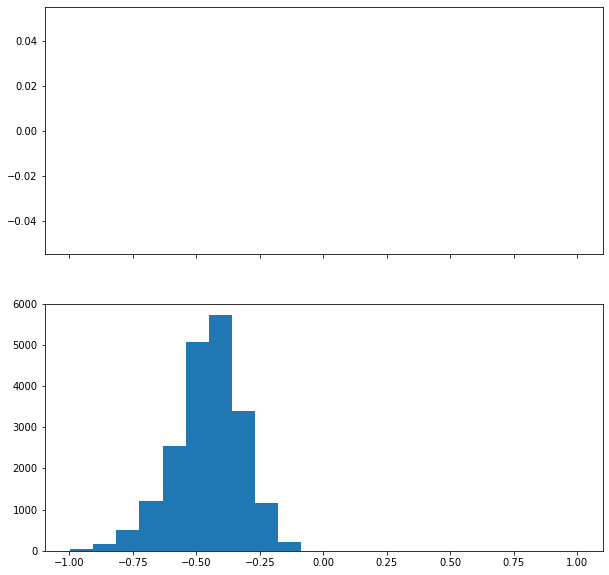

In [36]:
plot_histograms(entropy(preds), idx)

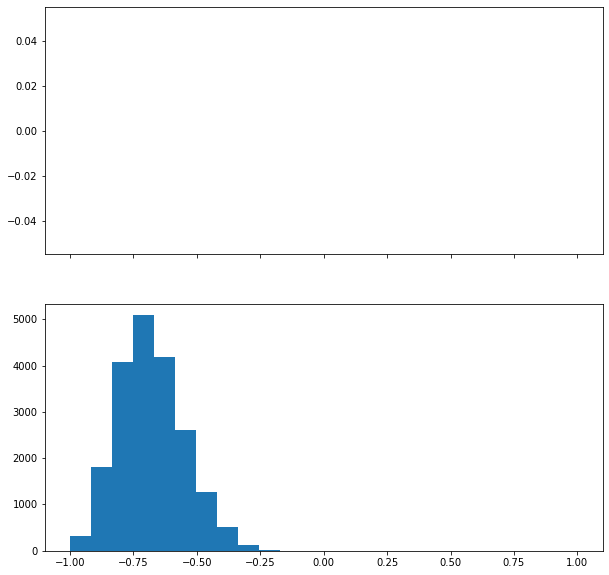

In [37]:
plot_histograms(entropy(dropout_mean), idx)

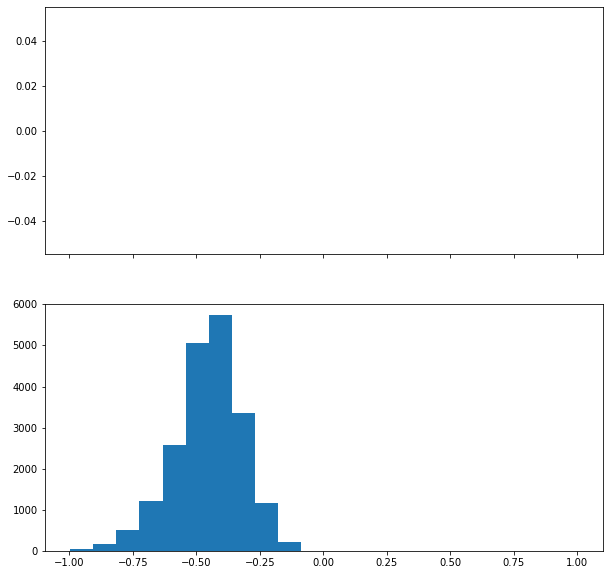

In [38]:
plot_histograms(entropy(laplace_mean), idx)

# Niepewność tak samo odległych

In [ ]:
plt.hist(dists)

In [ ]:
idx = np.where(np.abs(np.array(dists)-0.05) < 0.001)
plot_histograms(dropout_var, idx, preds)

In [ ]:
plot_histograms(laplace_var, idx, preds)

In [ ]:
plot_histograms(laplace_var, idx)

In [ ]:
plt.hist(dropout_var[np.where(preds>0.7)[0]])

In [ ]:
plt.hist(dropout_var)

In [ ]:
plt.hist(dists)

In [ ]:
idx = np.where(np.abs(np.array(dists)-0.05) < 0.001)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
ax1.hist(dropout_var[idx])
ax2.hist(dropout_var)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(laplace_var[idx])
ax2.hist(laplace_var)